In [2]:
import sys
import os
sys.path.append(os.path.expanduser('~/Desktop/diss/particles-cdssm'))
from particles_cdssm.collectors import ObservationPredictiveParticles, ObservationPredictiveMoments, NLPD
from particles.state_space_models import StochVol, Bootstrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import warnings
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.stattools import acf

warnings.filterwarnings('ignore')

# Import particles package components
import particles
from particles import state_space_models as ssm
from particles import mcmc
from particles import distributions
from particles.collectors import Moments



In [3]:
def fetch_sp500_data(start_date="2023-01-01", end_date="2024-11-01"):
    # Download S&P 500 data
    ticker = "^GSPC"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Calculate log returns (skip first day as we need previous close)
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1)) * 100
    data = data.dropna() #! remove any potential na's
    
    print(f"Downloaded {len(data)} trading days")
    print(f"Some basic stats: Mean={data['Returns'].mean():.3f}%, Std={data['Returns'].std():.2f}%")
    
    return data

# Fetch the data
data = fetch_sp500_data()


#! Train and test data split
# Function to split data into training and testing sets

def split_data(data, train_ratio=0.8):
    """Split data into training and testing sets"""
    n_total = len(data)
    n_train = int(n_total * train_ratio)
    
    train_data = data.iloc[:n_train].copy()
    test_data = data.iloc[n_train:].copy()
    
    print(f"Data split:")
    print(f"  Training: {len(train_data)} days ({train_data.index[0]} to {train_data.index[-1]})")
    print(f"  Testing:  {len(test_data)} days ({test_data.index[0]} to {test_data.index[-1]})")
    
    return train_data, test_data

# Split the data
train_data, test_data = split_data(data, train_ratio=0.8)
returns_train = train_data['Returns']
returns_test = test_data['Returns']

Downloaded 460 trading days
Some basic stats: Mean=0.087%, Std=0.81%
Data split:
  Training: 368 days (2023-01-04 00:00:00 to 2024-06-21 00:00:00)
  Testing:  92 days (2024-06-24 00:00:00 to 2024-10-31 00:00:00)


In [4]:
class StochasticVolatilityModel(ssm.StateSpaceModel):
    """
    Stochastic Volatility Model with logit-transformed φ parameter
    Parameters (μ, logit_phi, σ^2):
    - mu: long-run log-volatility level
    - logit_phi: logit-transformed persistence parameter
    - sigma_x: volatility of log-volatility
    
    Note: phi = exp(logit_phi) / (1 + exp(logit_phi))
    """
    
    def __init__(self, mu=-2.5, logit_phi=2.94, sigma_x=0.3):
        self.mu = mu
        self.logit_phi = logit_phi
        self.sigma_x = sigma_x
        
        # Convert logit_phi back to phi for internal calculations
        self.phi = np.exp(logit_phi) / (1 + np.exp(logit_phi))
        
    def PX0(self):
        """Initial distribution of log-volatility"""
        # Stationary distribution: X_0 ~ N(mu, sigma_x^2 / (1 - phi^2))
        var_stat = self.sigma_x**2 / (1 - self.phi**2)
        return particles.distributions.Normal(loc=self.mu, scale=np.sqrt(var_stat))
    
    def PX(self, t, xp):
        # State transition: X_t | X_{t-1}
        # X_{t-1} = xp
        mean = self.mu + self.phi * (xp - self.mu)
        return particles.distributions.Normal(loc=mean, scale=self.sigma_x)
    
    def PY(self, t, xp, x):
        """Observation distribution: Y_t | X_t"""
        # Y_t = exp(X_t/2) * eta_t where eta_t ~ N(0,1)
        volatility = np.exp(x / 2)
        return particles.distributions.Normal(loc=0.0, scale=volatility)

class BlackScholesModel:
    """
    Black-Scholes model with constant volatility
    """
    def __init__(self, volatility=0.2):
        self.volatility = volatility
    
    def fit(self, returns):
        """Fit the model to returns data"""
        # Calculate realized volatility (annualized)
        self.volatility = returns.std() * np.sqrt(252)
        return self
    
    def predict_volatility(self, n_periods):
        """Predict constant volatility for n periods"""
        return np.full(n_periods, self.volatility)
    
    def log_likelihood(self, returns):
        """Calculate log-likelihood of returns under constant volatility"""
        n = len(returns)
        vol_daily = self.volatility / np.sqrt(252)
        
        # Log-likelihood of normal distribution
        ll = -0.5 * n * np.log(2 * np.pi) - n * np.log(vol_daily) - \
             0.5 * np.sum((returns / vol_daily) ** 2)
        return ll



In [5]:
def run_particle_filter(model, returns, N=1000):
    """
    Run particle filter for stochastic volatility estimation
    """
    # Convert returns to numpy array
    y_data = returns.values
    T = len(y_data)
    
    # Create bootstrap filter
    fk_model = ssm.Bootstrap(ssm=model, data=y_data)
    
    # Run the algorithm
    pf = particles.SMC(fk=fk_model, N=N, collect=[Moments()])
    pf.run()
    
    # Filtering means and variances
    filtering_means = np.array([pf.summaries.moments[t]['mean'] for t in range(T)])
    filtering_vars = np.array([pf.summaries.moments[t]['var'] for t in range(T)])
    
    # Convert log-volatility to volatility percentage
    vol_estimates = np.exp(filtering_means / 2) * np.sqrt(252)  # Annualized volatility
    vol_std = np.sqrt(filtering_vars) * np.exp(filtering_means / 2) * np.sqrt(252)

    return {
        'log_vol_mean': filtering_means,
        'log_vol_var': filtering_vars,
        'vol_estimates': vol_estimates,
        'vol_std': vol_std,
        'particle_filter': pf
    }
def run_particle_smoother(model, returns, N=1000):
    """
    Simple particle smoother for volatility estimation
    """
    # Convert returns to numpy array
    y_data = returns.values
    T = len(y_data)
    
    # Run forward filter with history storage
    fk = ssm.Bootstrap(ssm=model, data=y_data)
    pf = particles.SMC(fk=fk, N=N, store_history=True)
    pf.run()
    
    # Try backward sampling for proper smoothing
    try:
        M = N // 10  # Number of backward trajectories
        paths = particles.backward_sampling(pf, M=M)
        
        # Get smoothed estimates from trajectories
        if paths.shape[0] == T:  # T x M shape
            smoothed_means = np.mean(paths, axis=1)
            smoothed_vars = np.var(paths, axis=1)
        else:  # M x T shape
            smoothed_means = np.mean(paths, axis=0)
            smoothed_vars = np.var(paths, axis=0)
            
    except:
        # Fallback: use filtering estimates with simple smoothing
        pf_filter = particles.SMC(fk=fk, N=N, collect=[Moments()])
        pf_filter.run()
        
        filtering_means = np.array([pf_filter.summaries.moments[t]['mean'] for t in range(T)])
        filtering_vars = np.array([pf_filter.summaries.moments[t]['var'] for t in range(T)])
        
        # Simple moving average smoothing (window=10)
        window = 10
        smoothed_means = np.convolve(filtering_means, np.ones(window)/window, mode='same')
        smoothed_vars = np.convolve(filtering_vars, np.ones(window)/window, mode='same')
    
    # Convert to annualized volatility percentage
    vol_estimates = np.exp(smoothed_means / 2) * np.sqrt(252)
    vol_std = np.sqrt(smoothed_vars) * np.exp(smoothed_means / 2) * np.sqrt(252)
    
    return {
        'log_vol_mean': smoothed_means,
        'log_vol_var': smoothed_vars,
        'vol_estimates': vol_estimates,
        'vol_std': vol_std
    }

In [6]:
def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains"""
    
    
    fig, axes = plt.subplots(1, len(param_names), figsize=(15, 4))
    if len(param_names) == 1:
        axes = [axes]
    
    for i, param in enumerate(param_names):
        # Calculate ACF
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i].plot(lags, autocorr, 'b-', linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF for {param}')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains"""
    from statsmodels.tsa.stattools import acf
    
    n_samples, n_params = chain.shape
    ess_values = []
    
    for i in range(n_params):
        # Calculate autocorrelation
        max_lags = min(n_samples // 4, 200)  # Don't use too many lags
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)
            
            # Find first negative autocorrelation or where it drops below 0.05
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if autocorrs[lag] <= 0.05:
                    cutoff = lag
                    break
            
            # Calculate integrated autocorrelation time
            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            
            # Effective sample size
            ess = n_samples / (2 * tau_int)
            ess_values.append(max(ess, 1))  # Ensure ESS is at least 1
            
        except:
            # Fallback calculation
            ess_values.append(n_samples / 10)  # Conservative estimate
    
    return np.array(ess_values)

def mcmc_diagnostics(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics"""
    print("\n📊 MCMC Convergence Diagnostics:")
    print("=" * 40)
    
    # Basic chain statistics
    n_total, n_params = chain.shape
    n_burned = len(burned_chain)
    
    print(f"Total iterations: {n_total}")
    print(f"Burn-in samples: {n_total - n_burned}")
    print(f"Post-burn samples: {n_burned}")
    
    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    for i, param in enumerate(param_names):
        print(f"  {param}: {ess[i]:.1f} ({ess[i]/n_burned:.1%} of total)")
    
    # Plot traces and ACF
    fig, axes = plt.subplots(2, n_params, figsize=(15, 8))
    if n_params == 1:
        axes = axes.reshape(-1, 1)
    
    for i, param in enumerate(param_names):
        # Trace plot
        axes[0, i].plot(chain[:, i], alpha=0.7)
        axes[0, i].axvline(x=n_total-n_burned, color='r', linestyle='--', 
                          label='Burn-in end')
        axes[0, i].set_title(f'Trace: {param}')
        axes[0, i].set_ylabel('Value')
        axes[0, i].grid(True, alpha=0.3)
        axes[0, i].legend()
        
        # Density plot
        axes[1, i].hist(burned_chain[:, i], bins=50, density=True, alpha=0.7)
        axes[1, i].set_title(f'Posterior: {param}')
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Density')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ACF plots
    plot_acf(burned_chain, param_names)
    
    return ess


In [15]:
def bayesian_parameter_estimation_numpyro(returns, n_warmup=1000, n_samples=2000, n_chains=4, n_burn=500):
    """
    Bayesian parameter estimation for SV model using NumPyro with NUTS (HMC variant).
    Uses non-centered reparameterization for better mixing.
    """
    print(f"🎯 Running NumPyro NUTS estimation ({n_chains} chains, {n_warmup} warmup, {n_samples} samples)...")
    
    # Convert returns to numpy array first (fix for pandas Series)
    returns_np = returns.values.astype(np.float32)  # Use float32 for efficiency
    
    # Empirical mu for prior centering (adjustment for log-returns in decimal)
    emp_mu = np.mean(np.log(returns_np**2 + 1e-16)) + 1.2704  # Bias correction
    print(f"Empirical mu estimate: {emp_mu:.2f}")
    
    # Convert to JAX array
    returns_jax = jnp.array(returns_np)
    
    def sv_model(returns):
        mu = numpyro.sample('mu', dist.Normal(loc=emp_mu, scale=2.0))
        
        # Logit reparam for phi in (0,1)
        logit_phi = numpyro.sample('logit_phi', dist.Normal(loc=2.94, scale=1.0))
        phi = numpyro.deterministic('phi', jnp.exp(logit_phi) / (1 + jnp.exp(logit_phi)))
        
        sigma_x = numpyro.sample('sigma_x', dist.InverseGamma(3, 0.5))
        
        T = returns.shape[0]
        
        # Non-centered: sample i.i.d innovations
        eta = numpyro.sample('eta', dist.Normal(0, 1), sample_shape=(T,))
        
        # Deterministically build h (log-vol) using scan for efficiency
        def build_h(carry, xs):
            t, eta_t = xs
            h_t = mu + phi * (carry - mu) + sigma_x * eta_t
            return h_t, h_t
        
        # Initial h_0 from stationary dist
        h_init = mu + (sigma_x / jnp.sqrt(1 - phi**2 + 1e-10)) * eta[0]  # Avoid div by zero
        
        # Scan over t=1 to T-1
        _, h_rest = jax.lax.scan(build_h, h_init, (jnp.arange(1, T), eta[1:]))
        h = jnp.concatenate([h_init[None], h_rest])
        
        numpyro.deterministic('h', h)
        
        # Observations (decimal returns)
        numpyro.sample('obs', dist.Normal(0.0, jnp.exp(h / 2)), obs=returns)
    
    # Set up NUTS sampler
    nuts_kernel = NUTS(sv_model)
    mcmc = MCMC(nuts_kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains, progress_bar=True)
    
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, returns=returns_jax)
    
    # Get samples (dict with 'mu', 'logit_phi', 'sigma_x', etc.; phi is deterministic)
    samples = mcmc.get_samples()
    
    # Compute phi samples from logit_phi
    phi_samples = jnp.exp(samples['logit_phi']) / (1 + jnp.exp(samples['logit_phi']))
    
    # Handle single vs multi-chain shaping
    is_single_chain = (samples['mu'].ndim == 1)
    if is_single_chain:
        burned_mu = samples['mu'][n_burn:]
        burned_phi = phi_samples[n_burn:]
        burned_sigma_x = samples['sigma_x'][n_burn:]
        # Reshape to (1, -1) for consistency in ESS etc.
        burned_mu = burned_mu[None, :]
        burned_phi = burned_phi[None, :]
        burned_sigma_x = burned_sigma_x[None, :]
    else:
        burned_mu = samples['mu'][:, n_burn:]
        burned_phi = phi_samples[:, n_burn:]
        burned_sigma_x = samples['sigma_x'][:, n_burn:]
    
    burned_samples = {
        'mu': burned_mu,
        'phi': burned_phi,
        'sigma_x': burned_sigma_x
    }
    
    # Chain for output (flatten chains)
    burned_chain = jnp.stack([burned_mu, burned_phi, burned_sigma_x], axis=-1).reshape(-1, 3)
    
    param_names = ['mu', 'phi', 'sigma_x']
    
    # Diagnostics: ESS on burned samples (expects shape (chains, samples))
    ess = {p: numpyro_ess(burned_samples[p]) for p in param_names}
    ess_values = [ess[p] for p in param_names]
    print("\n📊 MCMC Convergence Diagnostics:")
    print(f"Effective Sample Sizes: {ess}")
    
    # Traces and ACF use full samples (adjust for single chain)
    if is_single_chain:
        mu_full = samples['mu'][None, :]
        phi_full = phi_samples[None, :]
        sigma_x_full = samples['sigma_x'][None, :]
    else:
        mu_full = samples['mu']
        phi_full = phi_samples
        sigma_x_full = samples['sigma_x']
    
    full_samples_for_plot = {
        'mu': mu_full,
        'phi': phi_full,
        'sigma_x': sigma_x_full
    }
    
    for i, param in enumerate(param_names):
        param_samples = full_samples_for_plot[param]
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(param_samples.T, alpha=0.5)
        plt.title(f'Trace: {param}')
        plt.axvline(n_burn, color='r', linestyle='--')
        
        plt.subplot(1, 2, 2)
        lags = np.arange(50)
        autocorr = acf(param_samples.mean(axis=0), nlags=49)  # Avg over chains
        plt.plot(lags, autocorr)
        plt.axhline(0.05, color='r', linestyle='--')
        plt.axhline(-0.05, color='r', linestyle='--')
        plt.title(f'ACF: {param}')
        plt.show()
    
    # Parameter estimates from burned_chain
    param_estimates = {
        param: {'mean': jnp.mean(burned_chain[:, i]), 'std': jnp.std(burned_chain[:, i])}
        for i, param in enumerate(param_names)
    }
    
    # Also store logit_phi
    if is_single_chain:
        logit_phi_burned = samples['logit_phi'][n_burn:]
    else:
        logit_phi_burned = samples['logit_phi'][:, n_burn:].reshape(-1)
    logit_phi_estimates = {
        'mean': jnp.mean(logit_phi_burned),
        'std': jnp.std(logit_phi_burned)
    }
    
    return {
        'chain': jnp.stack([burned_mu, burned_phi, burned_sigma_x], axis=-1),
        'burned_chain': burned_chain,
        'estimates': param_estimates,
        'logit_phi_estimates': logit_phi_estimates,
        'effective_sample_size': ess_values,
        'param_names': param_names,
        'mcmc': mcmc  # For further inspection
    }

Downloaded 752 trading days
Some basic stats: Mean=0.027%, Std=1.10%
Data split:
  Training: 601 days (2022-01-04 00:00:00 to 2024-05-24 00:00:00)
  Testing:  151 days (2024-05-28 00:00:00 to 2024-12-31 00:00:00)
🎯 Running NumPyro NUTS estimation (4 chains, 5000 warmup, 20000 samples)...
Empirical mu estimate: -9.27


sample: 100%|██████████| 25000/25000 [00:10<00:00, 2374.40it/s, 10 steps of size 1.07e-01. acc. prob=0.87]



📊 MCMC Convergence Diagnostics:
Effective Sample Sizes: {'mu': 10852.39376283406, 'phi': 30814.269405900795, 'sigma_x': 33867.73447774947}


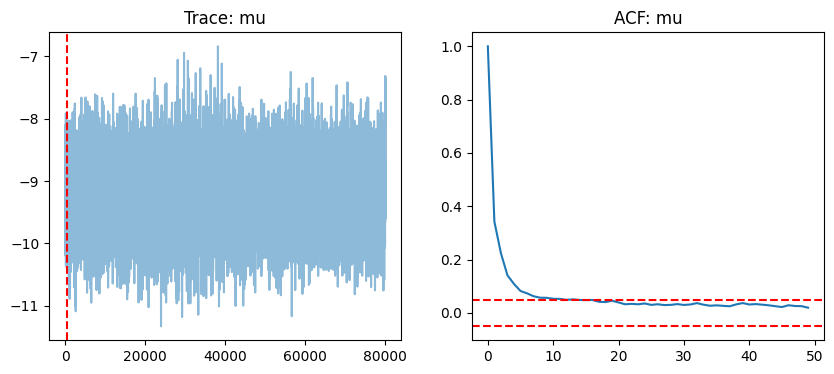

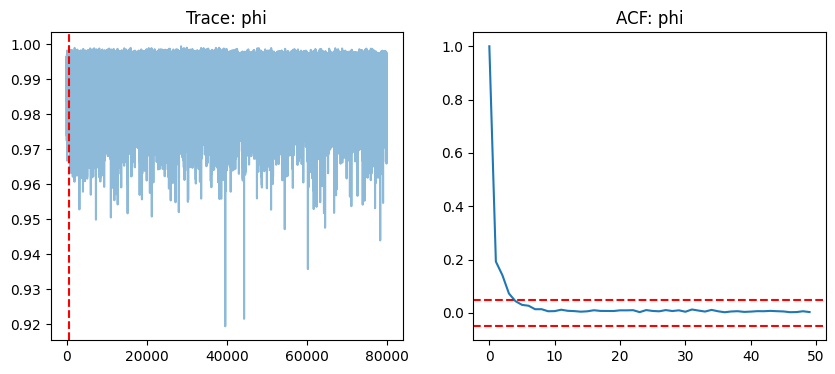

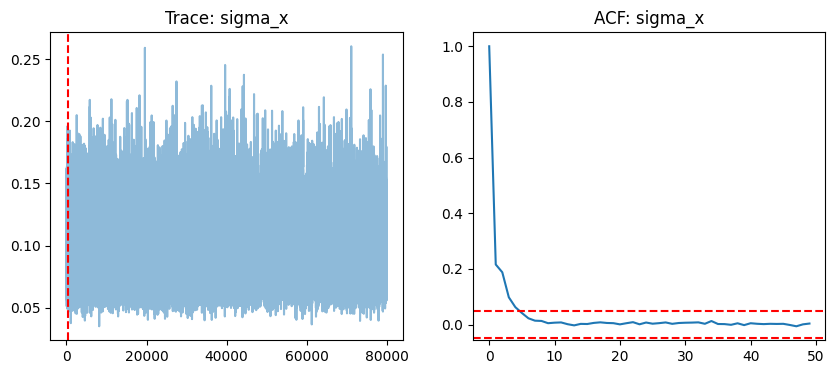

In [27]:
# Usage (replace your PMMH call)

# Your existing execution flow:
data = fetch_sp500_data(start_date="2022-01-01", end_date="2025-01-01")
train_data, test_data = split_data(data, train_ratio=0.8)
returns_train = train_data['Returns']
returns_test = test_data['Returns']


# Convert percentage returns to decimal returns
train_data_decimal = train_data.copy()
train_data_decimal['Returns'] = returns_train / 100
# Convert percentage returns to decimal returns
returns_train_decimal = returns_train / 100
returns_test_decimal = returns_test / 100
test_data_decimal = test_data.copy()
test_data_decimal['Returns'] = returns_test / 100


model = StochasticVolatilityModel()
filtering_results = run_particle_filter(model, returns_train, N=1000)
smoothing_results = run_particle_smoother(model, returns_train, N=1000)

mcmc_results = bayesian_parameter_estimation_numpyro(returns_train_decimal, n_warmup=5000, n_samples=20000)

🔄 Running online adaptive predictions...
 Running online adaptive predictions with 1000 particles, 1-step ahead...
Using parameters: μ=-9.223, φ=0.989, σ_x=0.097
Total data points: 752 (train: 601, test: 151)
🚀 Starting online SMC with predictive collectors...
✓ Online SMC completed
📊 Extracting predictions...
✓ Generated 152 online volatility predictions
  Range: 8.3% - 19.1%
  Mean: 13.2%
🔄 Comparing models with online adaptive predictions...

🔍 ENHANCED MODEL COMPARISON (with Online Predictions):
Black-Scholes fitted volatility: 18.4%
Online SV average volatility: 13.2%

Online Prediction Performance:
  Black-Scholes MAE:      12.77%
  Online Stochastic MAE:  4.49%
  Black-Scholes RMSE:     13.53%
  Online Stochastic RMSE: 5.41%
  Improvement in MAE:     64.8%
  Statistical significance: p = 0.0000


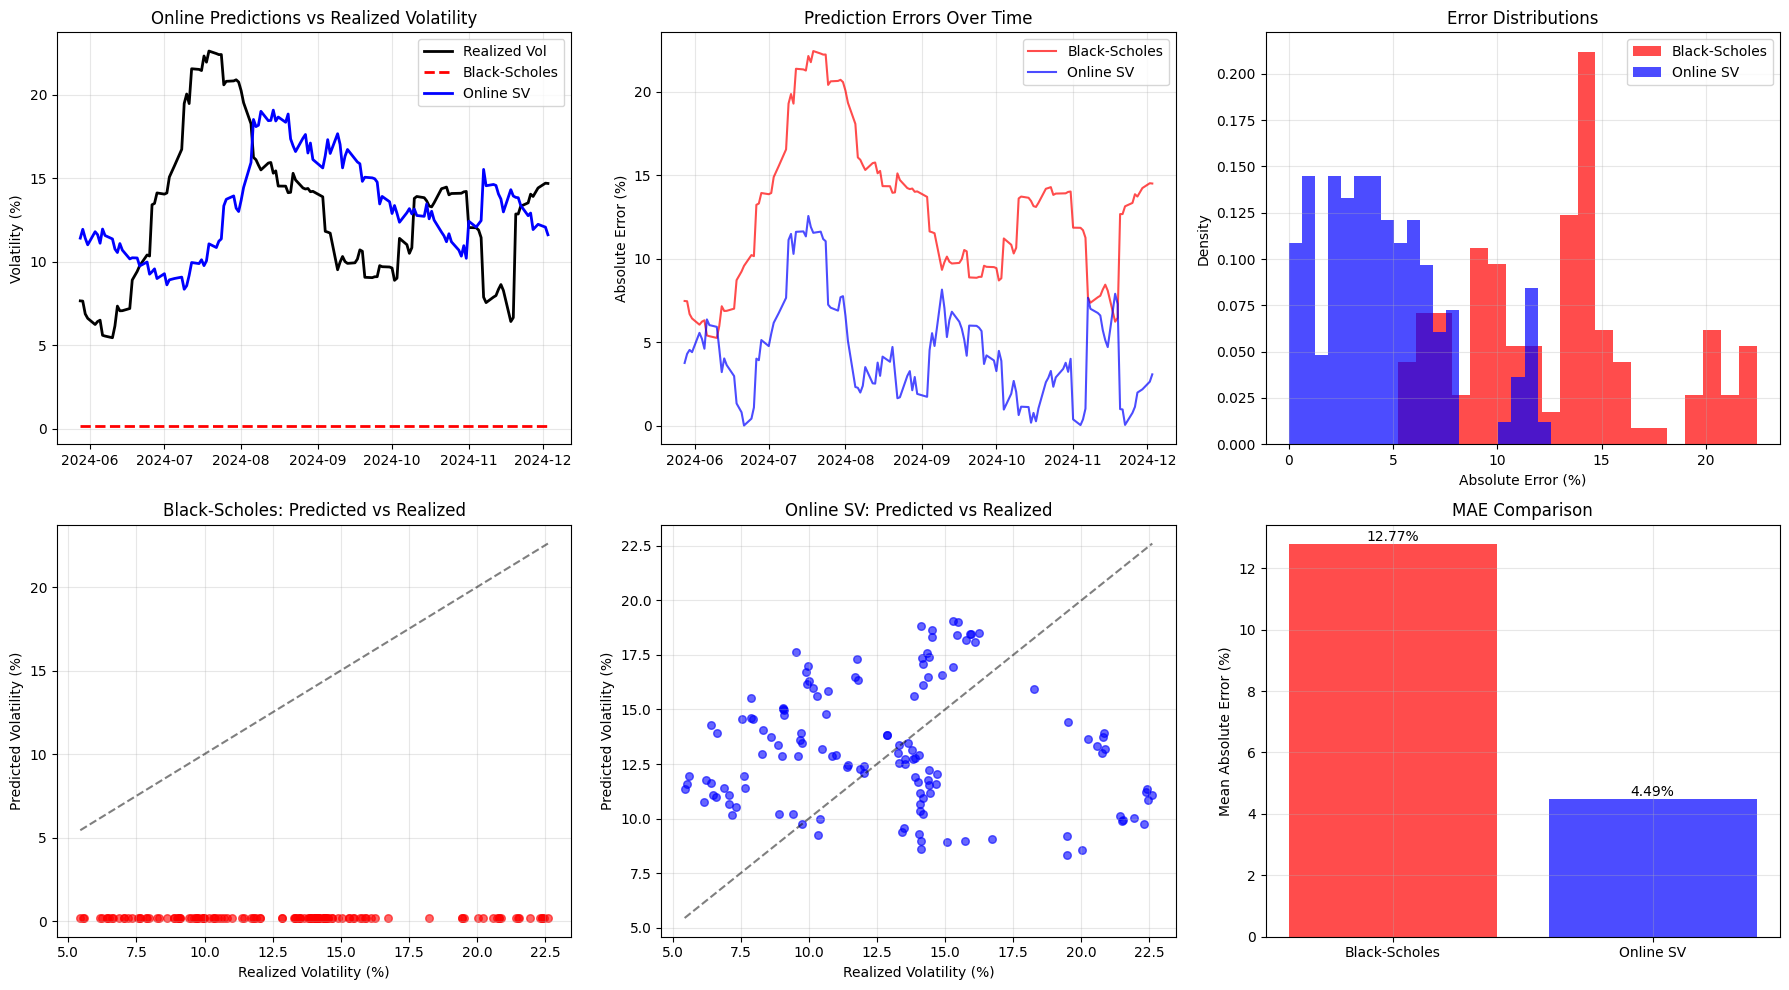

In [28]:
# =============================================================================
# HELPER FUNCTIONS FOR LOGIT TRANSFORMATION
# =============================================================================
# ADD these helper functions:

def phi_to_logit_phi(phi):
    """Convert phi to logit_phi"""
    return np.log(phi / (1 - phi))

def logit_phi_to_phi(logit_phi):
    """Convert logit_phi to phi"""
    return np.exp(logit_phi) / (1 + np.exp(logit_phi))

def get_logit_phi_prior_params(target_phi_mean=0.95, target_phi_std=0.02):
    """
    Helper to set reasonable prior for logit_phi based on desired phi distribution
    """
    target_logit_mean = phi_to_logit_phi(target_phi_mean)
    
    print(f"For phi ~ N({target_phi_mean}, {target_phi_std}²):")
    print(f"  Suggested logit_phi ~ N({target_logit_mean:.2f}, 1.0)")
    print(f"  This gives phi range roughly [{target_phi_mean-2*target_phi_std:.3f}, {target_phi_mean+2*target_phi_std:.3f}]")
    
    return target_logit_mean


# You can call this to understand the transformation:
# get_logit_phi_prior_params(target_phi_mean=0.95, target_phi_std=0.025)
def run_online_predictions(train_data, test_data, mcmc_results, N=1000, K=1):
    """
    Run online adaptive predictions using particle filter with predictive collectors
    
    Parameters:
    - train_data, test_data: your data splits
    - mcmc_results: results from MCMC parameter estimation
    - N: number of particles
    - K: number of steps ahead to predict (1 for next-day volatility)
    """
    print(f" Running online adaptive predictions with {N} particles, {K}-step ahead...")
    
    # Get estimated parameters from MCMC
    mu_est = mcmc_results['estimates']['mu']['mean']
    phi_est = mcmc_results['estimates']['phi']['mean']  # This is already phi, not logit_phi
    sigma_x_est = mcmc_results['estimates']['sigma_x']['mean']
    
    print(f"Using parameters: μ={mu_est:.3f}, φ={phi_est:.3f}, σ_x={sigma_x_est:.3f}")
    
    # Combine training and test data for online learning
    all_returns = pd.concat([train_data['Returns'], test_data['Returns']])
    y_data = all_returns.values
    n_train = len(train_data)
    n_total = len(all_returns)
    
    print(f"Total data points: {n_total} (train: {n_train}, test: {n_total - n_train})")
    
    # Create SV model with estimated parameters
    # Note: We need to convert back to logit_phi for the model
    logit_phi_est = phi_to_logit_phi(phi_est)
    ssm = StochasticVolatilityModel(mu=mu_est, logit_phi=logit_phi_est, sigma_x=sigma_x_est)
    
    # Create bootstrap Feynman-Kac model
    fk = Bootstrap(ssm=ssm, data=y_data)    
    # Define collectors for different types of predictions
    collectors = [
        ObservationPredictiveParticles(K=K),  # Full particle distributions
        ObservationPredictiveMoments(K=K),    # Just means and variances
        NLPD(K=K)                             # Negative log predictive density
    ]
    
    # Run SMC with predictive collectors
    print("🚀 Starting online SMC with predictive collectors...")
    smc_algo = particles.SMC(fk=fk, N=N, collect=collectors, store_history=True)
    smc_algo.run()
    print("✓ Online SMC completed")
    
    # Extract predictions
    print("📊 Extracting predictions...")
    
    # Get predictive particles (full distributions)
    predictive_particles = smc_algo.summaries.obs_predictive_particles
    
    # Get predictive moments (means and variances)
    predictive_moments = smc_algo.summaries.obs_predictive_moments
    
    # Get NLPD scores
    nlpd_scores = smc_algo.summaries.nlpd
    
    # Convert to volatility estimates
    # The predictions are for returns, we need to convert to volatility
    online_vol_estimates = []
    
    for t in range(len(predictive_moments)):
        if t >= n_train:  # Only for test period
            # Get predictive variance of returns
            pred_var = predictive_moments[t]['var']
            # Convert to annualized volatility percentage
            pred_vol = np.sqrt(pred_var) * np.sqrt(252) * 100  # Return var → daily vol → annual vol
            online_vol_estimates.append(pred_vol)
    
    online_vol_estimates = np.array(online_vol_estimates)
    
    print(f"✓ Generated {len(online_vol_estimates)} online volatility predictions")
    print(f"  Range: {online_vol_estimates.min():.1f}% - {online_vol_estimates.max():.1f}%")
    print(f"  Mean: {online_vol_estimates.mean():.1f}%")
    
    return {
        'online_vol_estimates': online_vol_estimates,
        'predictive_particles': predictive_particles,
        'predictive_moments': predictive_moments,
        'nlpd_scores': nlpd_scores,
        'smc_algo': smc_algo,
        'n_train': n_train
    }

def compare_models_online(train_data, test_data, mcmc_results, online_results):
    """
    Compare Black-Scholes vs Online Adaptive Stochastic Volatility models
    """
    print("\n🔍 ENHANCED MODEL COMPARISON (with Online Predictions):")
    print("=" * 60)
    
    returns_train = train_data['Returns']
    returns_test = test_data['Returns']
    
    # Fit Black-Scholes model
    bs_model = BlackScholesModel()
    bs_model.fit(returns_train)
    
    print(f"Black-Scholes fitted volatility: {bs_model.volatility * 100:.1f}%")
    print(f"Online SV average volatility: {online_results['online_vol_estimates'].mean():.1f}%")
    
    # Predictions
    n_test = len(returns_test)
    bs_predictions = bs_model.predict_volatility(n_test)
    sv_predictions = online_results['online_vol_estimates']
    
    # Calculate realized volatility (rolling window)
    window = 20
    realized_vol = returns_test.rolling(window=window).std() * np.sqrt(252) * 100
    realized_vol = realized_vol.dropna()
    
    # Align predictions with realized volatility
    min_length = min(len(realized_vol), len(bs_predictions), len(sv_predictions))
    realized_vol = realized_vol[:min_length]
    bs_aligned = bs_predictions[:min_length]
    sv_aligned = sv_predictions[:min_length]
    
    # Calculate errors
    bs_mae = np.mean(np.abs(bs_aligned - realized_vol))
    sv_mae = np.mean(np.abs(sv_aligned - realized_vol))
    
    bs_rmse = np.sqrt(np.mean((bs_aligned - realized_vol) ** 2))
    sv_rmse = np.sqrt(np.mean((sv_aligned - realized_vol) ** 2))
    
    # Statistical significance
    from scipy import stats
    bs_errors = np.abs(bs_aligned - realized_vol)
    sv_errors = np.abs(sv_aligned - realized_vol)
    t_stat, p_value = stats.ttest_rel(bs_errors, sv_errors)
    
    print(f"\nOnline Prediction Performance:")
    print(f"  Black-Scholes MAE:      {bs_mae:.2f}%")
    print(f"  Online Stochastic MAE:  {sv_mae:.2f}%")
    print(f"  Black-Scholes RMSE:     {bs_rmse:.2f}%")
    print(f"  Online Stochastic RMSE: {sv_rmse:.2f}%")
    print(f"  Improvement in MAE:     {((bs_mae - sv_mae) / bs_mae * 100):.1f}%")
    print(f"  Statistical significance: p = {p_value:.4f}")
    
    # Enhanced visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Time series comparison
    test_dates = returns_test.index[:min_length]
    axes[0, 0].plot(test_dates, realized_vol, 'k-', label='Realized Vol', linewidth=2)
    axes[0, 0].plot(test_dates, bs_aligned, 'r--', label='Black-Scholes', linewidth=2)
    axes[0, 0].plot(test_dates, sv_aligned, 'b-', label='Online SV', linewidth=2)
    axes[0, 0].set_title('Online Predictions vs Realized Volatility')
    axes[0, 0].set_ylabel('Volatility (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Prediction errors over time
    axes[0, 1].plot(test_dates, bs_errors, 'r-', alpha=0.7, label='Black-Scholes')
    axes[0, 1].plot(test_dates, sv_errors, 'b-', alpha=0.7, label='Online SV')
    axes[0, 1].set_title('Prediction Errors Over Time')
    axes[0, 1].set_ylabel('Absolute Error (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Error distributions
    axes[0, 2].hist(bs_errors, bins=20, alpha=0.7, label='Black-Scholes', color='red', density=True)
    axes[0, 2].hist(sv_errors, bins=20, alpha=0.7, label='Online SV', color='blue', density=True)
    axes[0, 2].set_title('Error Distributions')
    axes[0, 2].set_xlabel('Absolute Error (%)')
    axes[0, 2].set_ylabel('Density')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Scatter plots
    axes[1, 0].scatter(realized_vol, bs_aligned, alpha=0.6, color='red', s=30)
    axes[1, 0].plot([realized_vol.min(), realized_vol.max()], 
                    [realized_vol.min(), realized_vol.max()], 'k--', alpha=0.5)
    axes[1, 0].set_xlabel('Realized Volatility (%)')
    axes[1, 0].set_ylabel('Predicted Volatility (%)')
    axes[1, 0].set_title('Black-Scholes: Predicted vs Realized')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].scatter(realized_vol, sv_aligned, alpha=0.6, color='blue', s=30)
    axes[1, 1].plot([realized_vol.min(), realized_vol.max()], 
                    [realized_vol.min(), realized_vol.max()], 'k--', alpha=0.5)
    axes[1, 1].set_xlabel('Realized Volatility (%)')
    axes[1, 1].set_ylabel('Predicted Volatility (%)')
    axes[1, 1].set_title('Online SV: Predicted vs Realized')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Performance comparison
    methods = ['Black-Scholes', 'Online SV']
    mae_values = [bs_mae, sv_mae]
    colors = ['red', 'blue']
    bars = axes[1, 2].bar(methods, mae_values, color=colors, alpha=0.7)
    axes[1, 2].set_title('MAE Comparison')
    axes[1, 2].set_ylabel('Mean Absolute Error (%)')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, mae_values):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'bs_mae': bs_mae, 'sv_mae': sv_mae,
        'bs_rmse': bs_rmse, 'sv_rmse': sv_rmse,
        'improvement': (bs_mae - sv_mae) / bs_mae * 100,
        'p_value': p_value,
        'online_predictions': sv_aligned,
        'realized_vol': realized_vol
    }

# Run online adaptive predictions with the corrected data
print("🔄 Running online adaptive predictions...")
online_results = run_online_predictions(train_data_decimal, test_data_decimal, mcmc_results, N=1000, K=1)
# Compare models with online predictions
print("🔄 Comparing models with online adaptive predictions...")
online_comparison = compare_models_online(train_data_decimal, test_data_decimal, mcmc_results, online_results)

# Update results dictionary
results = {
    'train_data': train_data,
    'test_data': test_data,
    'filtering': filtering_results,
    'smoothing': smoothing_results,
    'mcmc': mcmc_results,
    'online_predictions': online_results,
    'online_comparison': online_comparison,
    'model': model
}

📊 Creating return distribution visualizations...
1. Predictive distributions at selected time points:


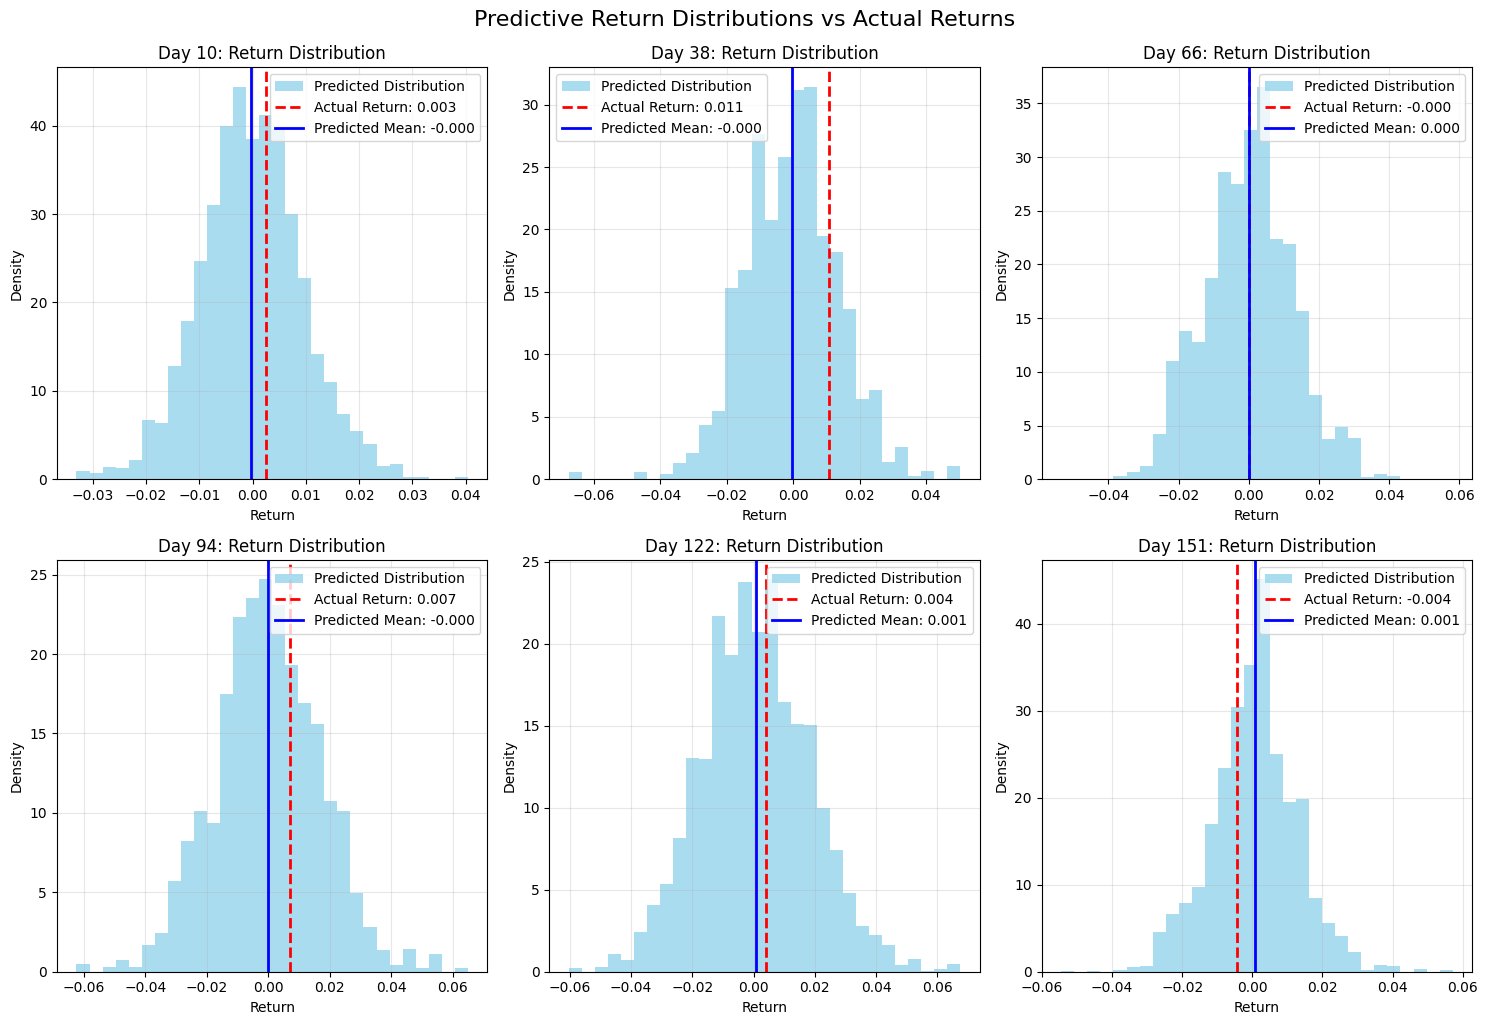

2. Prediction intervals and coverage:


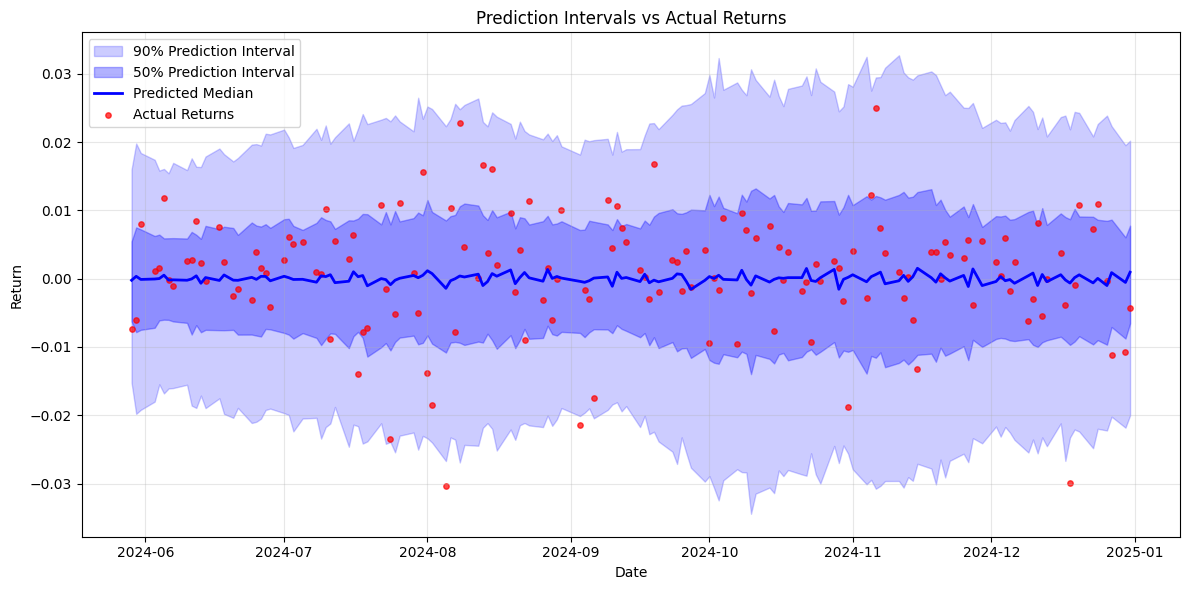

Prediction Interval Coverage:
  90% interval: 98.0% (target: 90%)
  50% interval: 75.3% (target: 50%)


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Get the predictive particles from your online results
predictive_particles = online_results['smc_algo'].summaries.obs_predictive_particles
n_train = len(train_data_decimal)
actual_returns = pd.concat([train_data_decimal['Returns'], test_data_decimal['Returns']]).values[n_train:]

# Function to create return distribution plots
def plot_return_distributions(predictive_particles, actual_returns, n_examples=6):
    """
    Plot predictive return distributions vs actual returns for selected time points
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Start from day 10 and select time points evenly spaced throughout the test period
    start_point = 9  # Day 10 (0-indexed)
    max_point = min(len(predictive_particles), len(actual_returns))-1
    time_points = np.linspace(start_point, max_point, n_examples, dtype=int)
    
    for i, t in enumerate(time_points):
        if t < len(predictive_particles) and t < len(actual_returns) and predictive_particles[t] is not None:
            # Get predictive particles for time t
            weights, particles = predictive_particles[t]
            
            # Plot predictive distribution
            axes[i].hist(particles, bins=30, density=True, alpha=0.7, 
                        label='Predicted Distribution', color='skyblue', weights=weights.W)
            
            # Add actual return as vertical line
            axes[i].axvline(actual_returns[t], color='red', linestyle='--', linewidth=2,
                           label=f'Actual Return: {actual_returns[t]:.3f}')
            
            # Add predicted mean
            pred_mean = np.average(particles, weights=weights.W)
            axes[i].axvline(pred_mean, color='blue', linestyle='-', linewidth=2,
                           label=f'Predicted Mean: {pred_mean:.3f}')
            
            axes[i].set_title(f'Day {t+1}: Return Distribution')
            axes[i].set_xlabel('Return')
            axes[i].set_ylabel('Density')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Predictive Return Distributions vs Actual Returns', y=1.02, fontsize=16)
    plt.show()

# Function to create quantile-based analysis
def plot_quantile_analysis(predictive_particles, actual_returns):
    """
    Analyze prediction quality using quantiles
    """
    n_points = min(len(predictive_particles), len(actual_returns))
    
    # Calculate prediction intervals
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    pred_quantiles = {q: [] for q in quantiles}
    
    for t in range(n_points):
        if predictive_particles[t] is not None:
            weights, particles = predictive_particles[t]
        else:
            continue
        # Calculate weighted quantiles
        sorted_idx = np.argsort(particles)
        sorted_particles = particles[sorted_idx]
        sorted_weights = weights.W[sorted_idx]
        cumsum_weights = np.cumsum(sorted_weights)
        
        for q in quantiles:
            # Find quantile
            idx = np.searchsorted(cumsum_weights, q)
            if idx < len(sorted_particles):
                pred_quantiles[q].append(sorted_particles[idx])
            else:
                pred_quantiles[q].append(sorted_particles[-1])
    
    # Plot quantile bands
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Only use dates where we have valid predictions
    valid_dates = []
    valid_actual_returns = []
    date_idx = 0
    for t in range(n_points):
        if predictive_particles[t] is not None:
            valid_dates.append(test_data_decimal.index[date_idx])
            valid_actual_returns.append(actual_returns[date_idx])
        date_idx += 1

    # Plot prediction intervals
    ax.fill_between(valid_dates, pred_quantiles[0.05], pred_quantiles[0.95], 
                    alpha=0.2, color='blue', label='90% Prediction Interval')
    ax.fill_between(valid_dates, pred_quantiles[0.25], pred_quantiles[0.75], 
                    alpha=0.3, color='blue', label='50% Prediction Interval')
    ax.plot(valid_dates, pred_quantiles[0.5], 'b-', linewidth=2, label='Predicted Median')

    # Plot actual returns
    ax.scatter(valid_dates, valid_actual_returns, color='red', alpha=0.7, s=15, label='Actual Returns')
    
    ax.set_title('Prediction Intervals vs Actual Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate coverage statistics
    coverage_90 = np.mean((np.array(valid_actual_returns) >= pred_quantiles[0.05]) & 
                     (np.array(valid_actual_returns) <= pred_quantiles[0.95]))
    coverage_50 = np.mean((np.array(valid_actual_returns) >= pred_quantiles[0.25]) & 
                     (np.array(valid_actual_returns) <= pred_quantiles[0.75]))
    
    print(f"Prediction Interval Coverage:")
    print(f"  90% interval: {coverage_90:.1%} (target: 90%)")
    print(f"  50% interval: {coverage_50:.1%} (target: 50%)")
    
    return coverage_90, coverage_50

# Run the visualizations
print("📊 Creating return distribution visualizations...")

# 1. Distribution snapshots at different time points (starting from day 10)
print("1. Predictive distributions at selected time points:")
plot_return_distributions(predictive_particles, actual_returns)

# 2. Quantile-based analysis
print("2. Prediction intervals and coverage:")
coverage_stats = plot_quantile_analysis(predictive_particles, actual_returns)

📊 Extracting and comparing NLPD scores...
Mean Predictive NLPD (SV): -3.2538
Mean NLPD (Black-Scholes): -3.2697
Debug: SV array shape = (151,), BS array shape = (151,)
Debug: SV length = 151, BS length = 151

📊 NLPD COMPARISON RESULTS:
Stochastic Volatility NLPD: -3.2538
Black-Scholes NLPD:        -3.2697
Improvement:                0.5%
Statistical significance:    p = 0.8465
✅ Stochastic Volatility model is BETTER (lower NLPD)


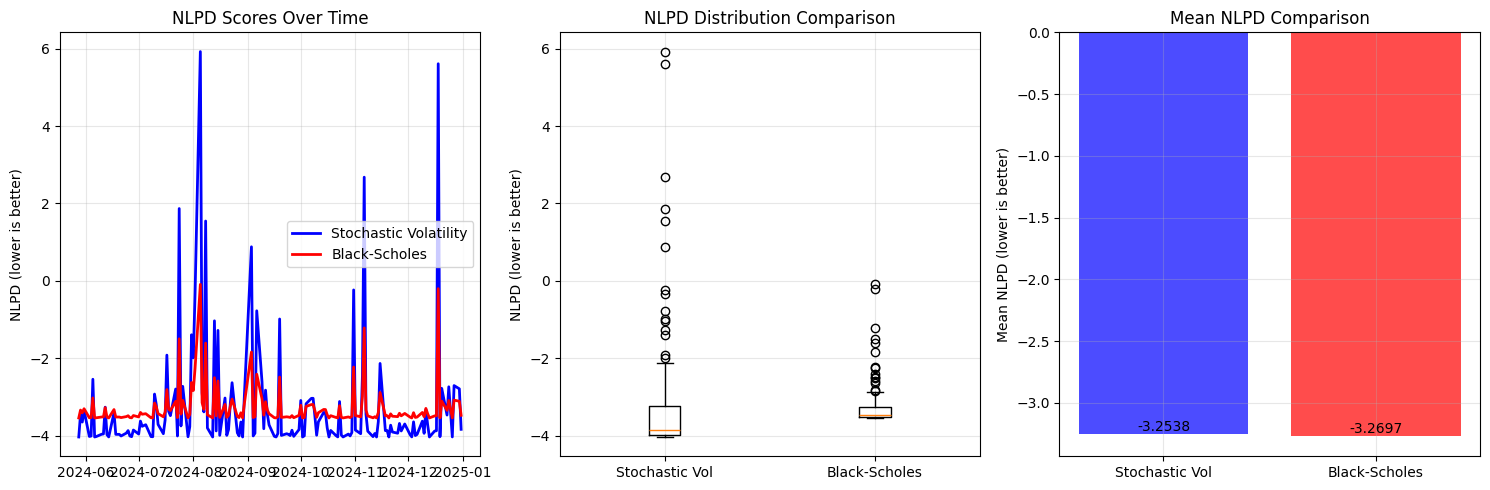


✅ NLPD analysis completed!
Results stored in 'nlpd_comparison' dictionary


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from jax import random
import jax.numpy as jnp

def compute_sv_predictive_nlpd(mcmc_results, train_data_decimal, test_data_decimal):
    """
    Optimized: Vectorized NLPD for SV using posterior latents.
    """
    # Hardcode defaults
    n_burn = 500
    n_chains = 4
    
    # Get posterior samples (flatten)
    samples = mcmc_results['mcmc'].get_samples(group_by_chain=False)
    n_burn_total = n_burn * n_chains
    burned_indices = slice(n_burn_total, None)
    
    mu = samples['mu'][burned_indices]
    logit_phi = samples['logit_phi'][burned_indices]
    phi = jnp.exp(logit_phi) / (1 + jnp.exp(logit_phi))
    sigma_x = samples['sigma_x'][burned_indices]
    eta = samples['eta'][burned_indices]  # (n_samples, T_train)
    
    # Vectorized h reconstruction
    def compute_h_single(mu_i, phi_i, sigma_x_i, eta_i):
        h_init = mu_i + (sigma_x_i / jnp.sqrt(1 - phi_i**2 + 1e-10)) * eta_i[0]
        def scan_fn(carry, eta_j):
            h_j = mu_i + phi_i * (carry - mu_i) + sigma_x_i * eta_j
            return h_j, h_j
        _, h_rest = jax.lax.scan(scan_fn, h_init, eta_i[1:])
        return jnp.concatenate([h_init[None], h_rest])
    
    compute_h = jax.vmap(compute_h_single)  # Vectorize over samples
    h = compute_h(mu, phi, sigma_x, eta)  # Shape (n_samples, T_train)
    
    test_returns = jnp.array(test_data_decimal['Returns'].values)
    sv_nlpd_scores = []
    
    rng_key = random.PRNGKey(0)
    for test_return in test_returns:
        rng_key, subkey = random.split(rng_key)
        eps = random.normal(subkey, shape=(len(mu),))
        h_future = mu + phi * (h[:, -1] - mu) + sigma_x * eps
        pred_scale = jnp.exp(h_future / 2)
        log_probs = dist.Normal(0.0, pred_scale).log_prob(test_return)
        mean_log_prob = jnp.mean(log_probs)
        nlpd = -mean_log_prob
        sv_nlpd_scores.append(nlpd.item())
    
    mean_nlpd = np.mean(sv_nlpd_scores)
    print(f"Mean Predictive NLPD (SV): {mean_nlpd:.4f}")
    return sv_nlpd_scores

# Calculate Black-Scholes NLPD for comparison
def calculate_black_scholes_nlpd(train_data_decimal, test_data_decimal):
    """
    Calculate NLPD scores for Black-Scholes model
    """
    # Fit Black-Scholes (constant volatility) on training data
    train_returns = train_data_decimal['Returns']
    bs_volatility = train_returns.std()  # Daily volatility (decimal)
    
    # Calculate NLPD for each test return
    test_returns = test_data_decimal['Returns'].values
    bs_nlpd_scores = []
    
    for return_val in test_returns:
        # Black-Scholes: assume normal distribution N(0, bs_volatility^2)
        log_prob = norm.logpdf(return_val, loc=0, scale=bs_volatility)
        nlpd = -log_prob  # Negative log probability density
        bs_nlpd_scores.append(nlpd)
    
    print(f"Mean NLPD (Black-Scholes): {np.mean(bs_nlpd_scores):.4f}")
    
    return bs_nlpd_scores

# Compare NLPD scores
def compare_nlpd_scores(sv_nlpd, bs_nlpd):
    """
    Compare NLPD scores between models
    """
    # Align lengths (in case of different sizes due to None values)
    min_length = min(len(sv_nlpd), len(bs_nlpd))
    sv_aligned = np.array(sv_nlpd[:min_length]).flatten()
    bs_aligned = np.array(bs_nlpd[:min_length])
    
    # Calculate summary statistics
    sv_mean = np.mean(sv_aligned)
    bs_mean = np.mean(bs_aligned)
    
    improvement = (bs_mean - sv_mean) / bs_mean * 100
    print(f"Debug: SV array shape = {sv_aligned.shape}, BS array shape = {bs_aligned.shape}")
    print(f"Debug: SV length = {len(sv_aligned)}, BS length = {len(bs_aligned)}")

    # Statistical test
    from scipy.stats import ttest_rel
    t_stat, p_value = ttest_rel(bs_aligned, sv_aligned)
    
    print(f"\n📊 NLPD COMPARISON RESULTS:")
    print(f"=" * 40)
    print(f"Stochastic Volatility NLPD: {sv_mean:.4f}")
    print(f"Black-Scholes NLPD:        {bs_mean:.4f}")
    print(f"Improvement:                {improvement:.1f}%")
    print(f"Statistical significance:    p = {p_value:.4f}")
    
    if improvement > 0:
        print(f"✅ Stochastic Volatility model is BETTER (lower NLPD)")
    else:
        print(f"❌ Black-Scholes model is better (lower NLPD)")
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Time series of NLPD scores
    dates = test_data_decimal.index[:min_length]
    axes[0].plot(dates, sv_aligned, 'b-', label='Stochastic Volatility', linewidth=2)
    axes[0].plot(dates, bs_aligned, 'r-', label='Black-Scholes', linewidth=2)
    axes[0].set_title('NLPD Scores Over Time')
    axes[0].set_ylabel('NLPD (lower is better)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot comparison
    axes[1].boxplot([sv_aligned, bs_aligned], labels=['Stochastic Vol', 'Black-Scholes'])
    axes[1].set_title('NLPD Distribution Comparison')
    axes[1].set_ylabel('NLPD (lower is better)')
    axes[1].grid(True, alpha=0.3)
    
    # Bar chart of means
    models = ['Stochastic Vol', 'Black-Scholes']
    means = [sv_mean, bs_mean]
    colors = ['blue', 'red']
    bars = axes[2].bar(models, means, color=colors, alpha=0.7)
    axes[2].set_title('Mean NLPD Comparison')
    axes[2].set_ylabel('Mean NLPD (lower is better)')
    axes[2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, means):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{value:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'sv_nlpd': sv_aligned,
        'bs_nlpd': bs_aligned,
        'sv_mean': sv_mean,
        'bs_mean': bs_mean,
        'improvement': improvement,
        'p_value': p_value
    }

# Run the NLPD analysis
print("📊 Extracting and comparing NLPD scores...")

# Compute SV NLPD scores
sv_nlpd_scores = compute_sv_predictive_nlpd(mcmc_results, train_data_decimal, test_data_decimal)

# Calculate BS NLPD scores
bs_nlpd_scores = calculate_black_scholes_nlpd(train_data_decimal, test_data_decimal)

# Compare the models
nlpd_comparison = compare_nlpd_scores(sv_nlpd_scores, bs_nlpd_scores)

print(f"\n✅ NLPD analysis completed!")
print(f"Results stored in 'nlpd_comparison' dictionary")